# 跳空研究
1. 跳空幅度和当日走势的关系
2. 跳空幅度和次日走势的关系

In [22]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from PositionManagerPlus import PositionManager

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        self.sideways_count = 0
        self.has_trade_count = 0
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-03-25"
    duration_str = "200 D"
    # ba.minutes_backtest(end_date, duration_str)
finally:
    if ba.ib:
        ba.ib.disconnect()

In [23]:
df = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')

# 查找缺口

In [24]:
import pandas as pd

# 假设 df 已存在且包含全小写的列：open, high, low, close，并已按日期升序排序

# 计算前一交易日的最高价/最低价
df['prev_high'] = df['high'].shift(1)
df['prev_low']  = df['low'].shift(1)

# 初始化缺口类型列
df['gap_type'] = 'no gap'

# 标记向上跳空与向下跳空
df.loc[df['low'] > df['prev_high'],  'gap_type'] = 'gap up'
df.loc[df['high'] < df['prev_low'],   'gap_type'] = 'gap down'

# 计算缺口大小
df['gap_size'] = 0.0
up   = df['gap_type'] == 'gap up'
down = df['gap_type'] == 'gap down'
df.loc[up,   'gap_size'] = df['low']  - df['prev_high']
df.loc[down, 'gap_size'] = df['prev_low'] - df['high']

# 筛选出所有存在跳空缺口的行
gaps_df = df[df['gap_type'] != 'no gap']

# 显示结果
gaps_df[['date', 'open','high','low','close','gap_type','gap_size']]


,date,open,high,low,close,gap_type,gap_size
32,2024-07-24,173.65,176.19,171.82,172.63,gap down,5.35
39,2024-08-02,166.44,168.51,164.67,166.66,gap down,0.37
40,2024-08-05,155.42,164.43,154.93,159.25,gap down,0.24
51,2024-08-20,166.91,168.64,166.82,167.18,gap up,0.13
67,2024-09-12,153.80,154.82,152.65,154.69,gap up,1.15
68,2024-09-13,155.43,158.38,155.21,157.46,gap up,0.39
70,2024-09-17,159.02,160.55,158.37,159.32,gap up,0.12
72,2024-09-19,163.70,163.79,161.34,162.14,gap up,0.84
98,2024-10-25,163.53,165.59,163.42,165.27,gap up,0.09
101,2024-10-30,180.75,182.02,174.05,174.46,gap up,3.67


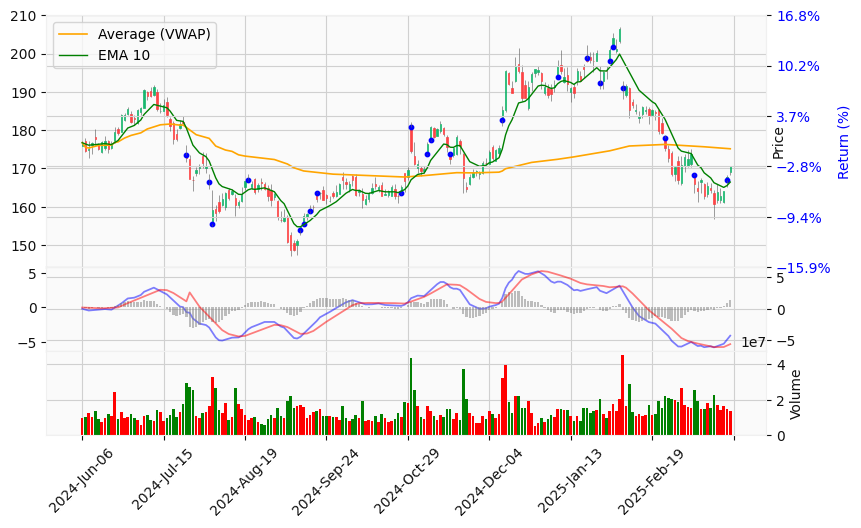

In [25]:
from PlotPlus import PlotPlus
pp = PlotPlus(df)
pp.plot_basic(style_type="candle")
pp.mark_point(gaps_df, 'open')
pp.show()

# 结论
1. 没有得出有效性
2. 缺口策略暂不可测